# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import Dataset as hgDataset
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import AutoTokenizer, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, set_seed, pipeline, DataCollatorForLanguageModeling

In [2]:
set_seed(42)

def check_gpu_memory() -> None:
    bytes_ = torch.cuda.memory_allocated()
    print(f'{bytes_ / (1024*1024)} MiB')
check_gpu_memory()

0.0 MiB


## Explore dataset

In [3]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME_XGLM = "facebook/xglm-564M" # specify model name
CONFIG_NAME = "ita_Latn"
SPLIT_NAME = 'devtest'
BATCH_SIZE_XGLM = 2 # for testing purposes, we start with a batch size of 2. You can change this later.
MODEL_NAME_GPT = "gpt2"
BATCH_SIZE_GPT = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cuda


In [4]:
# Explore a dataset

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder(DATA_SET_NAME, CONFIG_NAME, trust_remote_code=True)
print(ds_builder.info.description) # print the dataset description

The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [5]:
# print the features (columns) of the dataset
ds_builder.info.features

{'id': Value(dtype='int32', id=None),
 'URL': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None)}

In [6]:
# get the available splits
get_dataset_split_names(DATA_SET_NAME, CONFIG_NAME, trust_remote_code=True)

['dev', 'devtest']

## Load data, tokenize, and batchify

In [7]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [8]:
# load flores data for each language
datasets:dict[str, hgDataset] = {l : load_dataset(DATA_SET_NAME, l, split=SPLIT_NAME, trust_remote_code=True) for l in LANGUAGES} #type:ignore
check_gpu_memory()

0.0 MiB


In [9]:
# let's look at the English subset
datasets["eng_Latn"]

Dataset({
    features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
    num_rows: 1012
})

In [10]:
# let's look at an individal sample from the dataset
# TODO: your code goes here
datasets["eng_Latn"][0]

{'id': 1,
 'URL': 'https://en.wikinews.org/wiki/Toronto_team-led_research_on_Type_1_Diabetes_%27groundbreaking%27',
 'domain': 'wikinews',
 'topic': 'disease, research, canada',
 'has_image': 0,
 'has_hyperlink': 0,
 'sentence': '"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.'}

In [11]:
#For zero-padding
from torch.utils.data import default_collate
def collate_zero_padding(list_examples:list[dict]):
    if type(list_examples) is list: #else don't do anything 'cause batch size is 1
        keys = list_examples[0].keys()
        max_lengths = {
            k : max(map(lambda example: len(example[k]), list_examples)) for k in keys
        }
        for example in list_examples:
            for k in example:
                delta_length = max_lengths[k] - len(example[k])
                example[k] = torch.cat([example[k], torch.zeros(size=(delta_length,), dtype=torch.int)]).to(device=DEVICE)
    return default_collate(list_examples)

In [12]:
# construct a pytorch data loader for each dataset
def get_tokenizer(model_name:str):
    # load a pre-trained tokenizer from the huggingface hub
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # gpt2 does not have a padding token, so we have to add it manually
    if model_name == "gpt2":
        tokenizer.pad_token = tokenizer.unk_token
    return tokenizer

def get_dataloaders_for_model(datasets:dict[str, hgDataset], model_name:str, batch_size:int):
    # specify the tokenization function
    tokenizer = get_tokenizer(model_name)
    def tokenization(example):
        return tokenizer(example["sentence"], truncation=True)
    datasets_for_model = {}
    for l in datasets:
        datasets_for_model[l] = datasets[l].map(tokenization)
        datasets_for_model[l].set_format(type='torch', columns=['input_ids', 'attention_mask'])
    hugging_collate = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    return {l: DataLoader(datasets_for_model[l], batch_size, shuffle=False, collate_fn=hugging_collate) for l in LANGUAGES} #type:ignore

# class CustomDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, index):
#         return self.data[index]

In [13]:
dataloaders_for_xglm = get_dataloaders_for_model(datasets, MODEL_NAME_XGLM, BATCH_SIZE_XGLM)

for example in dataloaders_for_xglm["eng_Latn"]:
    print(example)
    break
check_gpu_memory()

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

{'input_ids': tensor([[     2,     57,   9796,   1920,    386,  10115, 174617,      8,  11746,
            295,    406,    155,    256,    489,      8,   5420,    491,   8978,
            155,   3964,     33,    113, 229405,      4,     68,    455,  23254,
              5,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1],
        [     2,   1497,      5,    128,  56480,   6762,      4,  18341,     48,
          42919,     94,  10352,  12996,   6640,   6073,     22,  66153,  82459,
              4,  10546,  82166,    414,     53,  42230,     48,     32, 143840,
             53,  44266,  55595,     48,     32,  84575,  77331,  29840,      6,
         181290,    196,    155,     32,  12729,     67,   2926,     22,   2565,
          15170,   4884,      5]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

## Load model

In [14]:
print(datasets['eng_Latn'][0:5])

{'id': [1, 2, 3, 4, 5], 'URL': ['https://en.wikinews.org/wiki/Toronto_team-led_research_on_Type_1_Diabetes_%27groundbreaking%27', 'https://en.wikinews.org/wiki/Toronto_team-led_research_on_Type_1_Diabetes_%27groundbreaking%27', 'https://en.wikinews.org/wiki/Toronto_team-led_research_on_Type_1_Diabetes_%27groundbreaking%27', 'https://en.wikinews.org/wiki/Nobel_Prize_in_Literature_Committee_abandons_efforts_to_contact_Bob_Dylan', 'https://en.wikinews.org/wiki/Nobel_Prize_in_Literature_Committee_abandons_efforts_to_contact_Bob_Dylan'], 'domain': ['wikinews', 'wikinews', 'wikinews', 'wikinews', 'wikinews'], 'topic': ['disease, research, canada', 'disease, research, canada', 'disease, research, canada', 'music', 'music'], 'has_image': [0, 0, 0, 0, 0], 'has_hyperlink': [0, 0, 0, 0, 0], 'sentence': ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the cli

In [15]:
# load pre-trained model from the huggingface hub
model_xglm:XGLMForCausalLM = XGLMForCausalLM.from_pretrained(MODEL_NAME_XGLM) #type:ignore

/home/latios/micromamba/envs/nntiproj/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [16]:
# put the model into evaluation mode
model_xglm.eval()
model_xglm.to(device=DEVICE) #type:ignore
check_gpu_memory()

2161.265625 MiB


In [22]:
def my_cross_entropy(logits:torch.Tensor, target_indices:torch.Tensor): #Unused
    loss = 0.
    N = 1
    for i in target_indices.shape:
        N *= i
    for i, _ in enumerate(logits):
        size = target_indices[i].shape
        for j in range(*size):
            k = target_indices[i, j]
            loss -= torch.log(torch.softmax(logits[i, j], -1)[k])
    return loss / N


def compute_per_language_per_minibatch_loss(dataloaders:dict[str, DataLoader], model:AutoModelForCausalLM, losses:dict[str, list]) -> None:
# iterate over the datset for each language and compute the cross-entropy loss per batch
# overwrites the values of losses
    with torch.no_grad(): #fundamental, or you build computational graph and quickly exhaust all memory
        for lang in LANGUAGES:
            for batch in dataloaders[lang]:
                batch.to(device=DEVICE)
                # input_ids:torch.Tensor = batch["input_ids"]
                output = model.forward(**batch)
                # weights:torch.Tensor = batch["attention_mask"].flatten()
                # loss_f = torch.nn.CrossEntropyLoss(reduction='mean')
                # loss = loss_f.forward(output.logits.flatten(end_dim=-2) * weights.reshape(weights.shape + (1,)) , input_ids.flatten())
                # losses[lang].append(loss)
                # losses[lang].append(my_cross_entropy(output.logits, input_ids))
                losses[lang].append(output.loss.to(device="cpu")) #type:ignore
                # check_gpu_memory()
        

## Visualize loss per language

In [23]:
def plot_mean_loss_per_language(losses:dict[str, list], model_name):
    # create a figure
    fig, axes = plt.subplots(figsize=(8, 5))

    # create a bar plot for each langauge
    x = range(len(LANGUAGES))
    #Replace every list of losses per minibatch with the mean loss per example
    y = list(map(lambda loss_list: torch.mean(torch.tensor(loss_list)), losses.values()))
    plt.bar(x, y)

    # format plot
    axes.set_xlabel("language") # x-axis label
    axes.set_xticks(x) # x-axis ticks
    axes.set_xticklabels(losses.keys()) # x-axis tick labels
    axes.set_ylabel("loss") # y-axis label
    axes.set_ylim(0, 9) # range of y-axis
    axes.set_title(model_name); # title

2169.390625 MiB


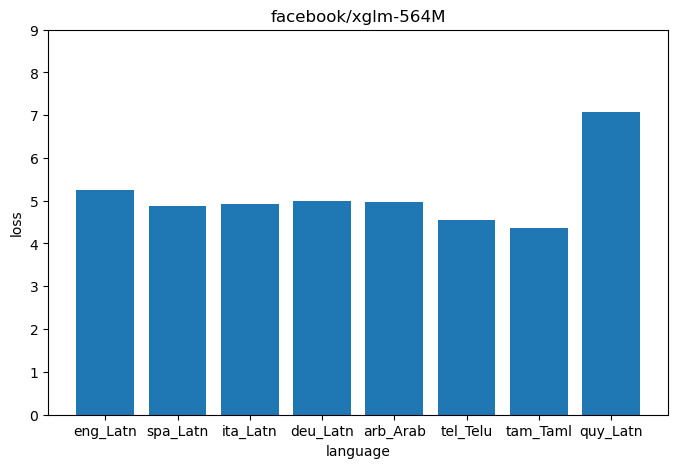

In [24]:
losses:dict[str, list] = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language
compute_per_language_per_minibatch_loss(dataloaders_for_xglm, model_xglm, losses)
plot_mean_loss_per_language(losses, MODEL_NAME_XGLM)
check_gpu_memory()

In [25]:
losses_shuffle = losses
print(losses)
print(torch.mean(torch.tensor(losses["eng_Latn"])))

{'eng_Latn': [tensor(3.9710), tensor(4.3371), tensor(5.1974), tensor(7.2989), tensor(7.6998), tensor(5.6611), tensor(5.1740), tensor(4.5982), tensor(4.1832), tensor(4.4488), tensor(5.7348), tensor(3.9995), tensor(5.1021), tensor(5.4184), tensor(5.5744), tensor(4.6286), tensor(4.9315), tensor(6.4608), tensor(4.9259), tensor(7.0408), tensor(5.1010), tensor(4.0065), tensor(4.7569), tensor(5.0249), tensor(6.5989), tensor(6.3374), tensor(5.3547), tensor(4.1799), tensor(5.1749), tensor(6.2392), tensor(5.2466), tensor(4.8166), tensor(5.9469), tensor(5.2470), tensor(4.3348), tensor(4.4204), tensor(4.3892), tensor(5.2291), tensor(5.3191), tensor(4.4833), tensor(5.4128), tensor(4.6831), tensor(6.9239), tensor(5.1310), tensor(4.8370), tensor(4.9325), tensor(6.0255), tensor(4.5834), tensor(5.3883), tensor(5.3083), tensor(4.9504), tensor(5.1418), tensor(5.5661), tensor(4.7163), tensor(5.3317), tensor(5.6366), tensor(6.5510), tensor(4.7855), tensor(5.0713), tensor(5.6290), tensor(5.2147), tensor(6.4

In [26]:
model_xglm.to(device="cpu") #type:ignore
check_gpu_memory()

8.125 MiB


## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well. 

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [27]:
dataloaders_for_gpt2 = get_dataloaders_for_model(datasets, MODEL_NAME_GPT, BATCH_SIZE_GPT)

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [28]:
model_gpt2 = AutoModelForCausalLM.from_pretrained(MODEL_NAME_GPT)
model_gpt2.eval()
model_gpt2.to(device=DEVICE)
losses_gpt:dict[str, list] = {lang: [] for lang in LANGUAGES}
compute_per_language_per_minibatch_loss(dataloaders_for_gpt2, model_gpt2, losses_gpt)

{'eng_Latn': [tensor(2.8264), tensor(3.5549), tensor(4.4899), tensor(5.4497), tensor(5.1808), tensor(4.5837), tensor(3.9445), tensor(3.9948), tensor(3.1970), tensor(3.8744), tensor(3.6736), tensor(3.3458), tensor(2.8716), tensor(4.5912), tensor(3.9888), tensor(4.0456), tensor(3.7046), tensor(3.5391), tensor(3.7426), tensor(4.4176), tensor(3.3688), tensor(2.7637), tensor(3.4672), tensor(3.3546), tensor(4.3698), tensor(4.2534), tensor(3.6285), tensor(3.3445), tensor(3.9417), tensor(4.0906), tensor(3.1620), tensor(3.6586), tensor(4.6647), tensor(3.8773), tensor(2.8098), tensor(3.3515), tensor(3.7360), tensor(4.2035), tensor(4.2780), tensor(2.9479), tensor(4.0605), tensor(3.6622), tensor(4.5831), tensor(4.3798), tensor(3.6347), tensor(3.3244), tensor(3.8267), tensor(3.2028), tensor(3.8486), tensor(3.7691), tensor(3.8635), tensor(3.3067), tensor(3.4303), tensor(3.3160), tensor(4.0516), tensor(3.3016), tensor(3.6590), tensor(4.2194), tensor(3.9129), tensor(4.0499), tensor(4.0612), tensor(2.8

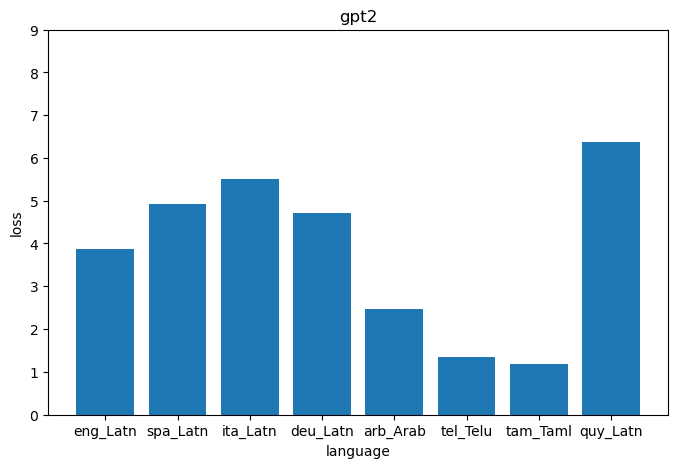

In [29]:
print(losses_gpt)
print(torch.mean(torch.tensor(losses_gpt["eng_Latn"])))
plot_mean_loss_per_language(losses_gpt, MODEL_NAME_GPT)

In [30]:
batch = next(iter(dataloaders_for_gpt2["eng_Latn"]))
batch.to(device=DEVICE)
input_ids:torch.Tensor = batch["input_ids"]

In [31]:
with torch.no_grad():
    output = model_gpt2.forward(**batch)
output.loss

tensor(2.8264, device='cuda:0')

In [32]:
weights:torch.Tensor = batch["attention_mask"].flatten()
loss_f = torch.nn.CrossEntropyLoss(reduction='mean')
loss = loss_f.forward(output.logits.flatten(end_dim=-2) * weights.reshape(weights.shape + (1,)) , input_ids.flatten())
print(loss)
print(my_cross_entropy(output.logits, input_ids))

tensor(10.7333, device='cuda:0')
tensor(10.9384, device='cuda:0')


In [33]:
model_gpt2.to(device="cpu")
check_gpu_memory()

34.28125 MiB


## XGLM text generation ##

In [39]:
prompt = "Hello, this is customer support,"
MAX_NEW_TOKENS = 100
RETURN_SEQUENCES = 5 #Unsupported for XGLM

In [40]:

generator_gpt = pipeline("text-generation", model=model_xglm, tokenizer=get_tokenizer(MODEL_NAME_XGLM))
gen_batch = generator_gpt(prompt, max_new_tokens=MAX_NEW_TOKENS)
for gen_text in gen_batch:
    print(gen_text['generated_text'])

Hello, this is customer support, I'm a customer support representative for the company. I'm a customer support representative for the company.


## GPT2 text generation ##

In [41]:
generator_gpt = pipeline("text-generation", model=model_gpt2, tokenizer=get_tokenizer(MODEL_NAME_GPT))
gen_batch = generator_gpt(prompt, max_new_tokens=MAX_NEW_TOKENS, num_return_sequences=RETURN_SEQUENCES)
for gen_text in gen_batch:
    print(gen_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hello, this is customer support, our primary responsibility under the law," said Rob Anderson, a spokesman for the Federal Bureau of Investigation, adding that the agency was "deeply upset and angered that something we have been under the banner of 'Operation Silent Spring' was able to compromise our law enforcement community."

Bureau of Alcohol, Tobacco, Firearms and Explosives Director John Homan announced last week that his agency had received reports that the agency had obtained or exchanged confidential materials. In a statement late Friday, Homan and his
Hello, this is customer support, and it will be my responsibility to notify customers within 6 days of order notification. In that case, I will need to contact the customer's supplier, who will either help or advise me. This is currently in the process of getting resolved here.

Thank you for your understanding and understanding.
Hello, this is customer support, where you can complain about a product.

As for our servers, we are

In [37]:
tokenizer_gpt = get_tokenizer(MODEL_NAME_GPT)
print(tokenizer_gpt)

tokenizer_xglm = get_tokenizer(MODEL_NAME_XGLM)
print(tokenizer_xglm)



GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
XGLMTokenizerFast(name_or_path='facebook/xglm-564M', vocab_size=256008, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'additional_special_tokens': ['<madeupword0>', '<madeupword1>', '<madeupword2>', '<madeupword3>', '<madeupword4>', '<madeupword5>', '<madeupword6>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, 

In [38]:
prompt = "Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura, ché la diritta via era smarrita."
tokenized_prompt_gpt = tokenizer_gpt(prompt)
tokenized_prompt_xglm = tokenizer_xglm(prompt)
print(tokenized_prompt_gpt)
print(tokenized_prompt_xglm)
print(tokenizer_gpt.decode(tokenized_prompt_gpt['input_ids']))
print(tokenizer_xglm.decode(tokenized_prompt_xglm['input_ids']))

{'input_ids': [45, 417, 502, 47802, 1619, 12172, 1084, 2566, 18216, 430, 410, 5350, 21504, 374, 270, 18657, 1872, 583, 555, 64, 384, 6780, 64, 267, 1416, 5330, 11, 442, 2634, 8591, 26672, 48519, 2884, 6980, 895, 283, 799, 64, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [2, 15330, 53191, 126, 210649, 43, 8031, 5390, 295, 147453, 14, 122, 252, 3109, 9, 129346, 9, 4, 46384, 24, 4826, 2706, 1172, 1451, 95577, 18069, 5], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura, ché la diritta via era smarrita.
</s> Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura, ché la diritta via era smarrita.


It looks like GPT2 has some trouble with knowing when to stop, whereas XGLM is well-behaved in this regards.\
GPT2 has a smaller max token sequence (1024 vs 2048) and a smaller vocabulary size (50257 vs 256008).\
We also noticed GPT2's token sequence for a given prompt is usually longer than XGLM's.
GTP2 has higher loss for italian: it cannot produce text in italian.